In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from tensorflow.keras.utils import load_img
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from sklearn.utils import resample
from skimage.segmentation import slic, mark_boundaries
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [1]:
!pip install tensorflow==2.9.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attemp

# **get data and preprocessing**

In [3]:
images = glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg', recursive=False)
print(len(images))
import fnmatch
normal = fnmatch.filter(images, '*NORMAL*')
bacteria = fnmatch.filter(images, '*_bacteria_*')
virus = fnmatch.filter(images, '*_virus_*')
x = []
y = []
for img in images:
    x.append(img)
    if img in normal:
        y.append('NORMAL')
    elif img in bacteria:
        y.append('PNEUMONIA')
    elif img in virus:
        y.append('PNEUMONIA')
    else:
        #break
        print('no class')
x = np.array(x)
y = np.array(y)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(x, name= 'filepaths')
Lseries = pd.Series(y, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)


5216


show original data

PNEUMONIA    3875
NORMAL       1341
Name: labels, dtype: int64

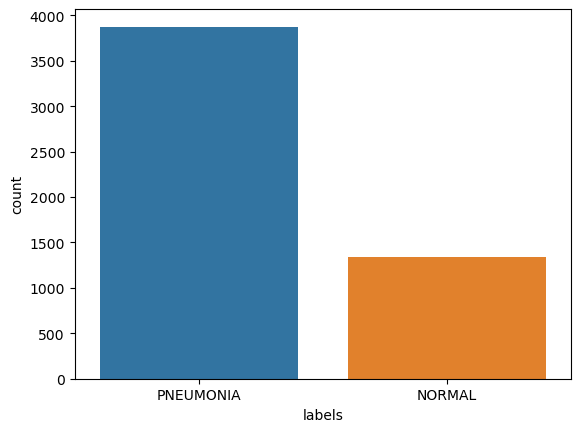

In [5]:
sns.countplot(x='labels', data=df)
df.labels.value_counts()

data after resampling

NORMAL       1341
PNEUMONIA    1341
Name: labels, dtype: int64

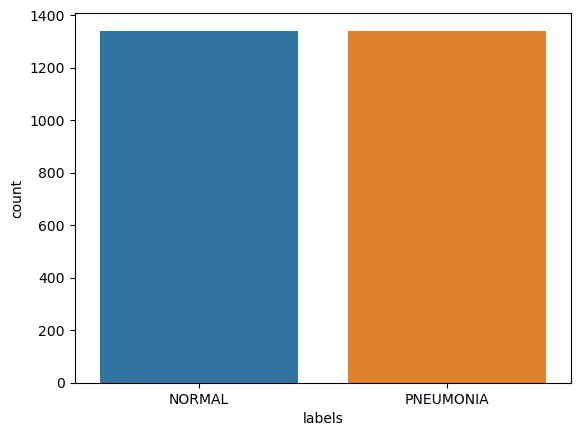

In [6]:
df_majority = df[df['labels']=='NORMAL']
df_minority = df[df.labels=='PNEUMONIA']
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
sns.countplot(x='labels', data=df_upsampled)
df_upsampled.labels.value_counts()


In [7]:
train_set,test_val = train_test_split(df_upsampled,train_size= 0.8, shuffle= True, random_state= 123)
valid_set, test_set = train_test_split(test_val,  train_size= 0.6, shuffle= True, random_state= 123)

Hyper parameters

In [8]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
learning_rate=0.001
epochs = 10  
classes=['NORMAL','PNEUMONIA']

preprocess

In [9]:
train_gen  = ImageDataGenerator(rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
test_gen  = ImageDataGenerator()
train_gen = train_gen.flow_from_dataframe( train_set, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = test_gen.flow_from_dataframe( valid_set, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = test_gen.flow_from_dataframe( test_set, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2145 validated image filenames belonging to 2 classes.
Found 322 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


show data

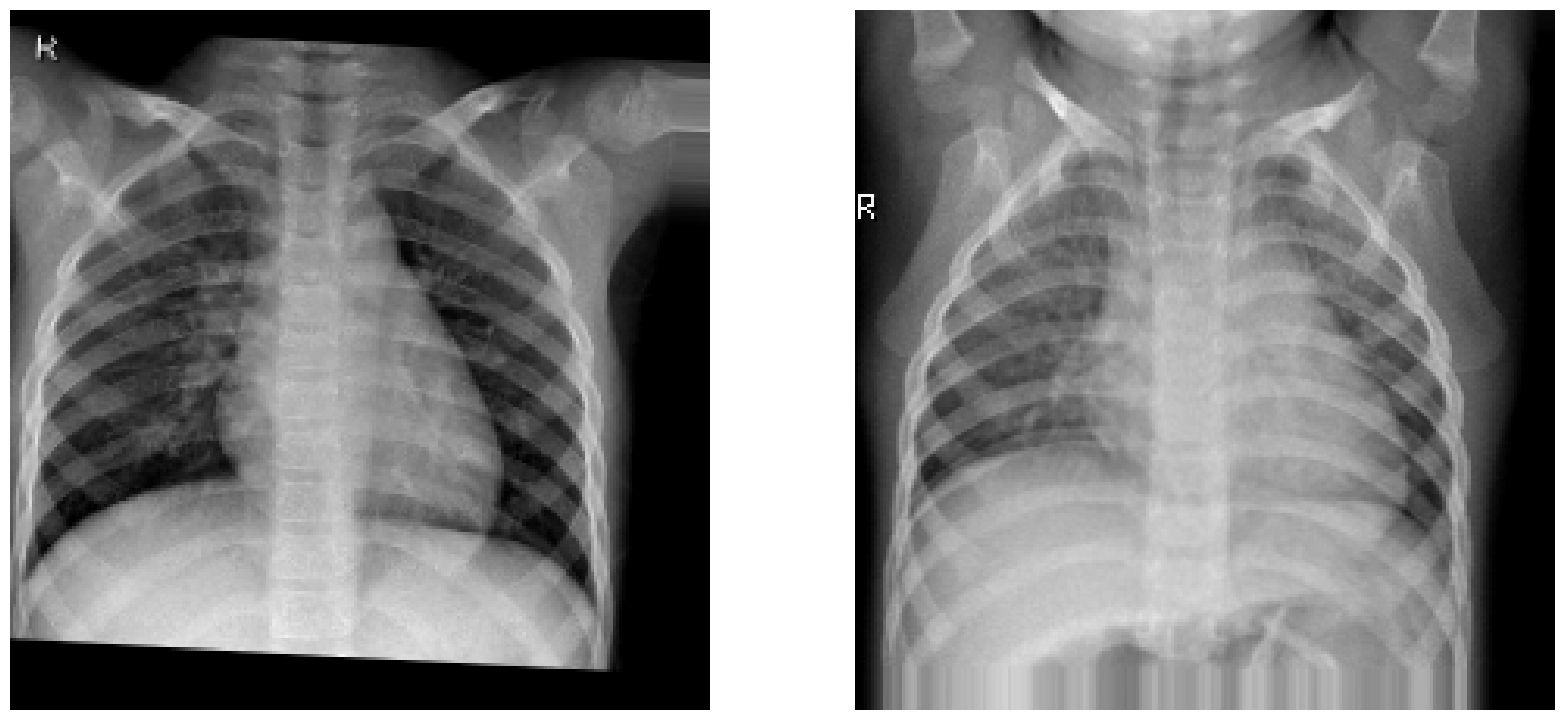

In [10]:
images, labels = next(train_gen)      # get a batch size samples from the generator
plt.figure(figsize= (20, 20))

for i in range(2):
    plt.subplot(2, 2, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index  
    plt.axis('off')
plt.show()

# model

useful callbacks

In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.best_only.hdf5".format('save')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                              patience=5, verbose=1, mode='auto', 
                              epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) 
callbacks_list = [checkpoint, early,reduceLROnPlat]

In [36]:


base_model = tf.keras.applications.resnet50.ResNet50(input_shape=img_shape, include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(2, activation='softmax')
])

model.compile(Adamax(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=callbacks_list)

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                       

# fit model

In [37]:
model.load_weights('/kaggle/working/save.best_only.hdf5')


graphs for evalute

In [38]:

test_loss, test_score = model.evaluate(test_gen, batch_size=24)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

14/14 [==============================] - 3s 236ms/step - loss: 0.0952 - accuracy: 0.9674
Loss on test set:  0.09518498927354813
Accuracy on test set:  0.9674418568611145


In [39]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

14/14 [==============================] - 4s 206ms/step


<Axes: >

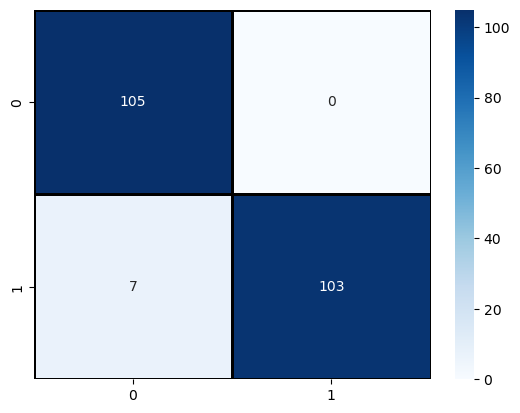

In [40]:
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [41]:
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = test_gen.classes
    Y_pred = cnn.predict_generator(test_gen, steps = len(test_gen))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

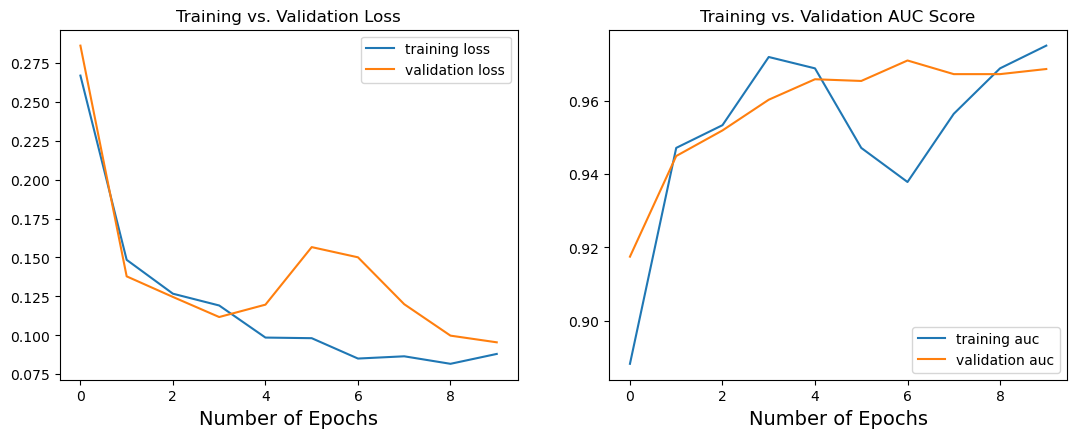

In [42]:
create_charts(model, history)


In [43]:
print(classification_report( test_gen.classes,y_pred, target_names= classes))


              precision    recall  f1-score   support

      NORMAL       0.94      1.00      0.97       105
   PNEUMONIA       1.00      0.94      0.97       110

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215



In [44]:

# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.94
Precision of the model is 1.00


In [45]:

from lime import lime_image
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


<Figure size 2000x2000 with 0 Axes>

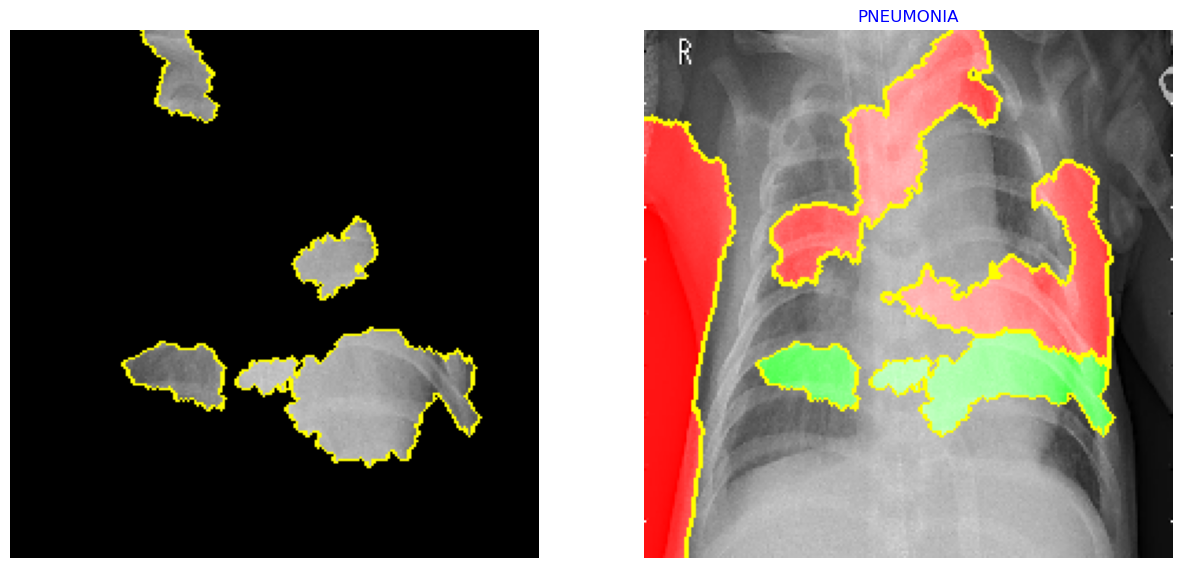

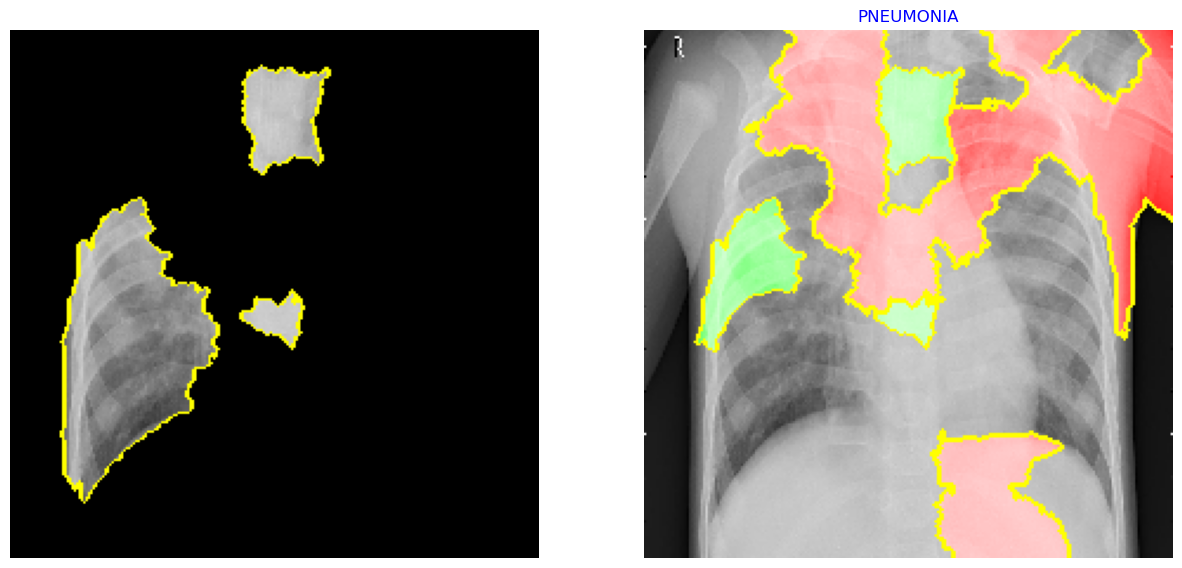

In [47]:
g_dict = test_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(test_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(2):
    image = images[i] / 255       # scales data to range (0 - 255)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    explanation = explainer.explain_instance(image.astype('double'), model.predict,  
                                         top_labels=2, hide_color=0, num_samples=1000)
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


